In [26]:
import numpy as np
import time
from case_studies import *  # Assuming implemented test functions
from math import sqrt
from matplotlib import pyplot as plt

def is_positive_definite(H):
    try:
        np.linalg.cholesky(H)
        return True
    except np.linalg.LinAlgError:
        return False

def conjugate_gradient(Q, g, tol=1e-6, max_iter=None):
    n = len(g)
    if max_iter is None:
        max_iter = n
    
    x = np.zeros(n)
    r = -g.copy()  # Initial residual
    p = r.copy()
    rs_old = r.dot(r)
    
    for i in range(max_iter):
        Ap = Q @ p
        alpha = rs_old / p.dot(Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = r.dot(r)
        
        if np.sqrt(rs_new) < tol:
            break
        
        beta = rs_new / rs_old
        p = r + beta * p
        rs_old = rs_new
    
    return x, i + 1

def approximate_newton(x0, f, df, Hf, eta_type='linear', tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'cg_steps': [], 'fval': []}
    
    for k in range(1, max_iter+1):
        g = df(x)
        Q = Hf(x)
        
        if not is_positive_definite(Q):
            raise ValueError("Hessian not positive definite")
        
        norm_g = np.linalg.norm(g)
        
        if eta_type == "linear":
            eta_k = 1/2  # Fixed value, slow convergence
        elif eta_type == "superlinear":
            eta_k = 1/2 * min(1/2, sqrt(norm_g))
        elif eta_type == "quadratic":
            eta_k = 1/2 * min(1/2, norm_g)
        else:
            raise ValueError("Invalid eta_type. Choose from 'linear', 'superlinear', 'quadratic'.")
        
        eps_k = eta_k * norm_g  # CG stopping criterion
        
        p, cg_steps = conjugate_gradient(Q, g, tol=eps_k)
        
        # Armijo line search
        step = 1.0
        f0 = f(x)
        while f(x + step*p) > f0 + 1e-4*step*g.dot(p):
            step *= 0.5
        
        x += step*p
        
        # Track convergence
        history['grad_norm'].append(np.linalg.norm(g))
        history['cg_steps'].append(cg_steps)
        history['fval'].append(f0)
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

def newtons_method(x0, f, df, Hf, tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'fval': []}
    
    for _ in range(max_iter):
        g = df(x)
        Q = Hf(x)
        p = np.linalg.solve(Q, -g)
        x += p
        
        history['grad_norm'].append(np.linalg.norm(g))
        history['fval'].append(f(x))
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

def steepest_descent(x0, f, df, tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'fval': []}
    
    for _ in range(max_iter):
        g = df(x)
        p = -g
        
        # Line search
        step = 1.0
        f0 = f(x)
        while f(x + step*p) > f0 - 1e-4*step*g.dot(g):
            step *= 0.5
        
        x += step*p
        
        history['grad_norm'].append(np.linalg.norm(g))
        history['fval'].append(f0)
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

F1 D=100


Approx Newton (linear):
 - Time Taken: 0.1102s
 - Iterations: 15
 - Final Gradient Norm: 2.12e-02
 - Total CG Steps: 156

Approx Newton (superlinear):
 - Time Taken: 0.0133s
 - Iterations: 12
 - Final Gradient Norm: 2.82e-09
 - Total CG Steps: 407

Approx Newton (quadratic):
 - Time Taken: 0.0196s
 - Iterations: 11
 - Final Gradient Norm: 1.06e-10
 - Total CG Steps: 424

Classical Newton:
 - Time Taken: 0.0019s
 - Iterations: 2
 - Final Gradient Norm: 2.09e-13
 - Total CG Steps: 0

Steepest Descent:
 - Time Taken: 0.0040s
 - Iterations: 15
 - Final Gradient Norm: 5.61e+02
 - Total CG Steps: 0


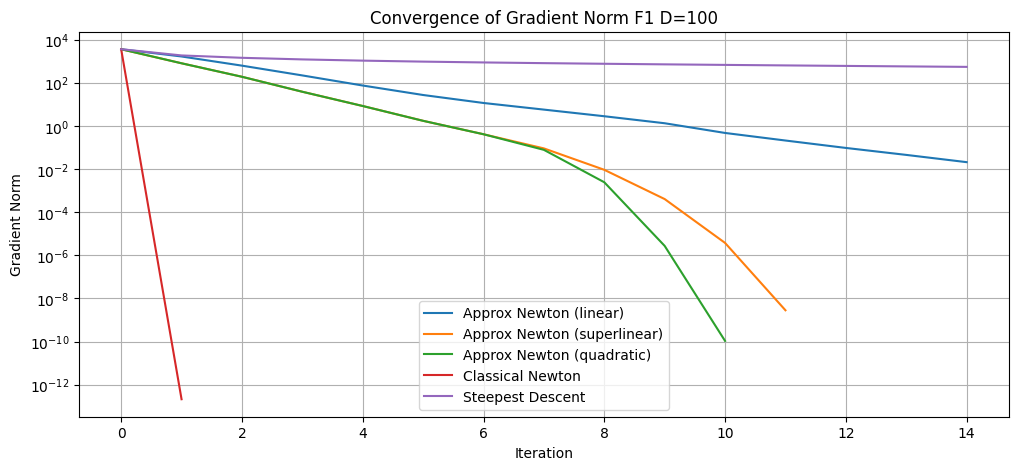

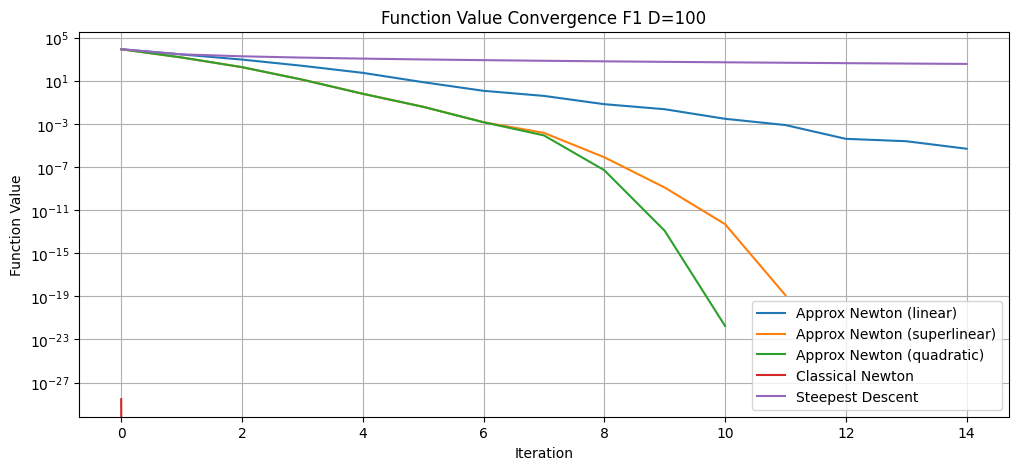

In [28]:
# Benchmarking setup
d = 100
x0 = np.random.randn(d)
methods = {
    'Approx Newton (linear)': lambda: approximate_newton(x0, f1, df1, Hf1, 'linear'),
    'Approx Newton (superlinear)': lambda: approximate_newton(x0, f1, df1, Hf1, 'superlinear'),
    'Approx Newton (quadratic)': lambda: approximate_newton(x0, f1, df1, Hf1, 'quadratic'),
    'Classical Newton': lambda: newtons_method(x0, f1, df1, Hf1),
    'Steepest Descent': lambda: steepest_descent(x0, f1, df1)
}

# Run benchmarks
results = {}
for name, method in methods.items():
    start = time.time()
    x_opt, hist = method()
    elapsed = time.time() - start
    results[name] = {
        'time': elapsed,
        'iterations': len(hist['grad_norm']),
        'final_grad': hist['grad_norm'][-1],
        'cg_steps': sum(hist.get('cg_steps', [])),
        'convergence': hist['grad_norm'],
        'function_values' : hist['fval']
    }

# Generate convergence plots and analysis
# Print results
for name, res in results.items():
    print(f"\n{name}:")
    print(f" - Time Taken: {res['time']:.4f}s")
    print(f" - Iterations: {res['iterations']}")
    print(f" - Final Gradient Norm: {res['final_grad']:.2e}")
    if 'cg_steps' in res:
        print(f" - Total CG Steps: {res['cg_steps']}")

# Plot convergence
plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['convergence'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Convergence of Gradient Norm F1 D=100')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['function_values'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Function Value Convergence F1 D=100')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

F4 Analysis


Approx Newton (linear):
 - Time Taken: 0.1120s
 - Iterations: 12
 - Final Gradient Norm: 9.53e-12
 - Total CG Steps: 14

Approx Newton (superlinear):
 - Time Taken: 0.0059s
 - Iterations: 11
 - Final Gradient Norm: 4.41e-09
 - Total CG Steps: 22

Approx Newton (quadratic):
 - Time Taken: 0.0058s
 - Iterations: 10
 - Final Gradient Norm: 2.68e-09
 - Total CG Steps: 26

Classical Newton:
 - Time Taken: 0.0270s
 - Iterations: 8
 - Final Gradient Norm: 7.06e-10
 - Total CG Steps: 0

Steepest Descent:
 - Time Taken: 0.0035s
 - Iterations: 10
 - Final Gradient Norm: 2.30e-07
 - Total CG Steps: 0


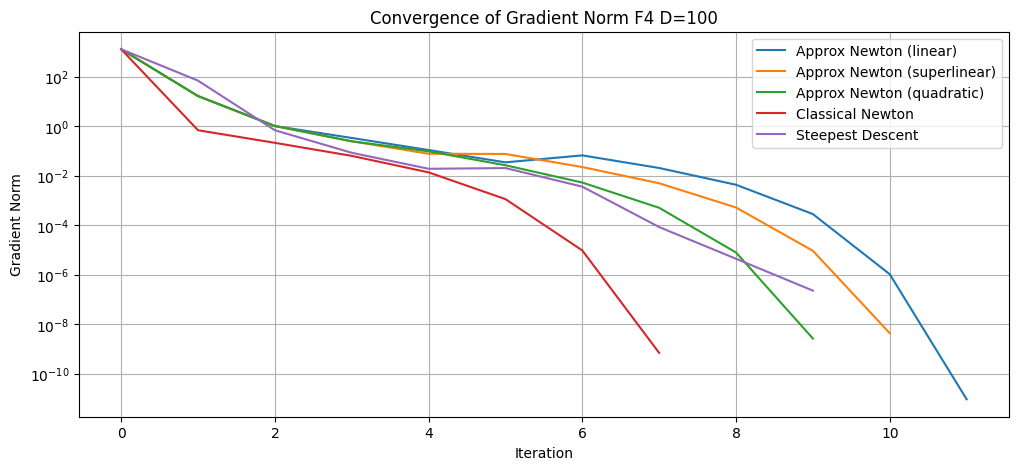

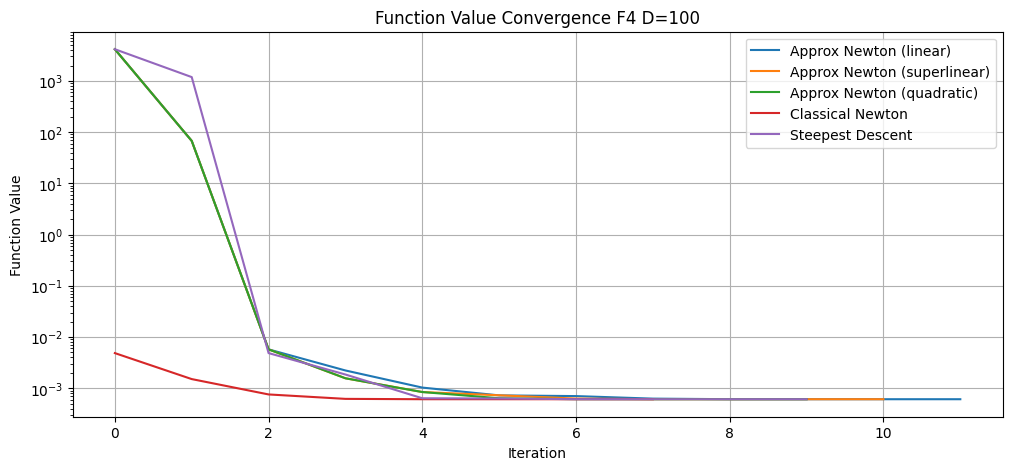

In [23]:
# Benchmarking setup
d = 100
x0 = np.random.randn(d)
methods = {
    'Approx Newton (linear)': lambda: approximate_newton(x0, f4, df4, Hf4, 'linear'),
    'Approx Newton (superlinear)': lambda: approximate_newton(x0, f4, df4, Hf4, 'superlinear'),
    'Approx Newton (quadratic)': lambda: approximate_newton(x0, f4, df4, Hf4, 'quadratic'),
    'Classical Newton': lambda: newtons_method(x0, f4, df4, Hf4),
    'Steepest Descent': lambda: steepest_descent(x0, f4, df4)
}

# Run benchmarks
results = {}
for name, method in methods.items():
    start = time.time()
    x_opt, hist = method()
    elapsed = time.time() - start
    results[name] = {
        'time': elapsed,
        'iterations': len(hist['grad_norm']),
        'final_grad': hist['grad_norm'][-1],
        'cg_steps': sum(hist.get('cg_steps', [])),
        'convergence': hist['grad_norm'],
        'function_values' : hist['fval']
    }

# Generate convergence plots and analysis
# Print results
for name, res in results.items():
    print(f"\n{name}:")
    print(f" - Time Taken: {res['time']:.4f}s")
    print(f" - Iterations: {res['iterations']}")
    print(f" - Final Gradient Norm: {res['final_grad']:.2e}")
    if 'cg_steps' in res:
        print(f" - Total CG Steps: {res['cg_steps']}")

# Plot convergence
plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['convergence'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Convergence of Gradient Norm F4 D=100')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['function_values'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Function Value Convergence F4 D=100')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


Approx Newton (linear):
 - Time Taken: 0.1089s
 - Iterations: 15
 - Final Gradient Norm: 9.01e-06
 - Total CG Steps: 59

Approx Newton (superlinear):
 - Time Taken: 0.0113s
 - Iterations: 15
 - Final Gradient Norm: 3.54e-06
 - Total CG Steps: 117

Approx Newton (quadratic):
 - Time Taken: 0.4477s
 - Iterations: 15
 - Final Gradient Norm: 3.52e-06
 - Total CG Steps: 286

Classical Newton:
 - Time Taken: 0.0092s
 - Iterations: 15
 - Final Gradient Norm: 3.31e-06
 - Total CG Steps: 0

Steepest Descent:
 - Time Taken: 0.0017s
 - Iterations: 15
 - Final Gradient Norm: 1.62e-02
 - Total CG Steps: 0


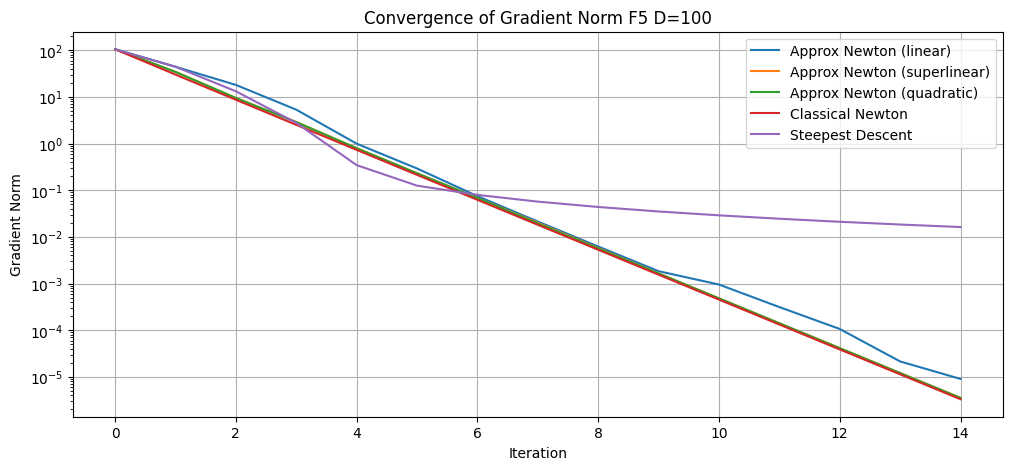

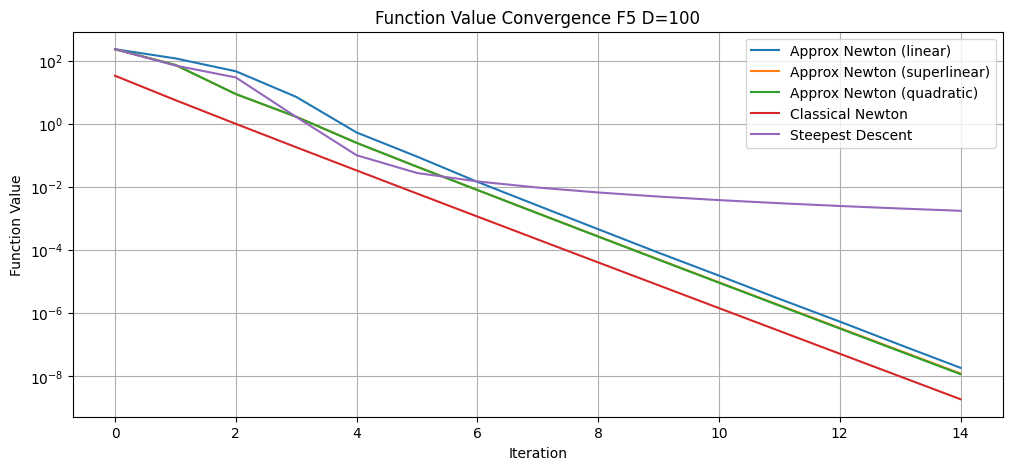

In [24]:
# Benchmarking setup
d = 100
x0 = np.random.randn(d)
methods = {
    'Approx Newton (linear)': lambda: approximate_newton(x0, f5, df5, Hf5, 'linear'),
    'Approx Newton (superlinear)': lambda: approximate_newton(x0, f5, df5, Hf5, 'superlinear'),
    'Approx Newton (quadratic)': lambda: approximate_newton(x0, f5, df5, Hf5, 'quadratic'),
    'Classical Newton': lambda: newtons_method(x0, f5, df5, Hf5),
    'Steepest Descent': lambda: steepest_descent(x0, f5, df5)
}

# Run benchmarks
results = {}
for name, method in methods.items():
    start = time.time()
    x_opt, hist = method()
    elapsed = time.time() - start
    results[name] = {
        'time': elapsed,
        'iterations': len(hist['grad_norm']),
        'final_grad': hist['grad_norm'][-1],
        'cg_steps': sum(hist.get('cg_steps', [])),
        'convergence': hist['grad_norm'],
        'function_values' : hist['fval']
    }

# Generate convergence plots and analysis
# Print results
for name, res in results.items():
    print(f"\n{name}:")
    print(f" - Time Taken: {res['time']:.4f}s")
    print(f" - Iterations: {res['iterations']}")
    print(f" - Final Gradient Norm: {res['final_grad']:.2e}")
    if 'cg_steps' in res:
        print(f" - Total CG Steps: {res['cg_steps']}")

# Plot convergence
plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['convergence'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Convergence of Gradient Norm F5 D=100')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['function_values'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Function Value Convergence F5 D=100')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()